In [1]:
# EPLORING ONE-DIMENSIONAL DATA


def normal_cdf(x, mu=0,sigma=1):
    return (1 + math.erf((x - mu) / math.sqrt(2) / sigma)) / 2


def inverse_normal_cdf(p, mu=0, sigma=1, tolerance=0.00001):
    """find approximate inverse using binary search"""
    # if not standard, compute standard and rescale
    if mu != 0 or sigma != 1:
        return mu + sigma * inverse_normal_cdf(p, tolerance=tolerance)

    low_z, low_p = -10.0, 0            # normal_cdf(-10) is (very close to) 0
    hi_z,  hi_p  =  10.0, 1            # normal_cdf(10)  is (very close to) 1
    while hi_z - low_z > tolerance:
        mid_z = (low_z + hi_z) / 2     # consider the midpoint
        mid_p = normal_cdf(mid_z)      # and the cdf's value there
        if mid_p < p:
            # midpoint is still too low, search above it
            low_z, low_p = mid_z, mid_p
        elif mid_p > p:
            # midpoint is still too high, search below it
            hi_z, hi_p = mid_z, mid_p
        else:
            break

    return mid_z

In [2]:
#consider the two following sets of data:

import math
import random
random.seed(0)

# uniform between -100 and 100
uniform = [200 * random.random() - 100 for _ in range(10000)]

# normal distribution with mean 0, standard deviation 57
normal = [57 * inverse_normal_cdf(random.random())
          for _ in range(10000)] 

In [3]:
from matplotlib import pyplot as plt
from collections import Counter

def bucketize(point, bucket_size):
    """floor the point to the next lower multiple of bucket_size"""
    return bucket_size * math.floor(point / bucket_size)

def make_histogram(points, bucket_size):
    """buckets the points and counts how many in each bucket"""
    return Counter(bucketize(point, bucket_size) for point in points)

def plot_histogram(points, bucket_size, title=""):
    histogram = make_histogram(points, bucket_size)
    plt.bar(histogram.keys(), histogram.values(), width=bucket_size)
    plt.title(title)
    plt.show()

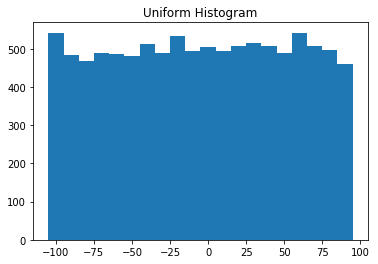

In [4]:
plot_histogram(uniform, 10, "Uniform Histogram")

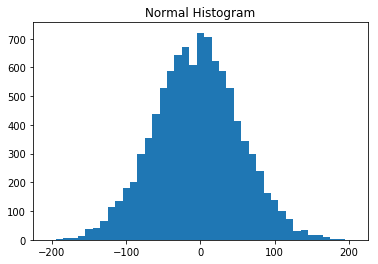

In [5]:
plot_histogram(normal, 10, "Normal Histogram")

In [6]:
# TWO DIMENSIONS 

def random_normal():
    """returns a random draw from a standard normal distribution"""
    return inverse_normal_cdf(random.random())

xs = [random_normal() for _ in range(1000)]
ys1 = [ x + random_normal() / 2 for x in xs]
ys2 = [-x + random_normal() / 2 for x in xs]

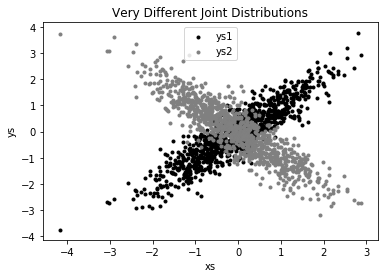

In [7]:
plt.scatter(xs, ys1, marker='.', color='black', label='ys1')
plt.scatter(xs, ys2, marker='.', color='gray',  label='ys2')
plt.xlabel('xs')
plt.ylabel('ys')
plt.legend(loc=9)
plt.title("Very Different Joint Distributions")
plt.show()

# If you were to run plot_histogram on ys1 and ys2 you’d get very similar looking plots, But each has a very 
# different joint distribution with xs 

In [8]:
# This difference would also be apparent if you looked at the correlations:

def mean(x):
    return sum(x) / len(x)

def dot(v, w):
    """v_1 * w_1 + ... + v_n * w_n"""
    return sum(v_i * w_i
               for v_i, w_i in zip(v, w))

def sum_of_squares(v):
    """v_1 * v_1 + ... + v_n * v_n"""
    return dot(v, v)

def de_mean(x):
    """translate x by subtracting its mean (so the result has mean 0)"""
    x_bar = mean(x)
    return [x_i - x_bar for x_i in x]

def variance(x):
    """assumes x has at least two elements"""
    n = len(x)
    deviations = de_mean(x)
    return sum_of_squares(deviations) / (n - 1)

def standard_deviation(x):
    return math.sqrt(variance(x))

def covariance(x, y):
    n = len(x)
    return dot(de_mean(x), de_mean(y)) / (n - 1)

def correlation(x, y):
    stdev_x = standard_deviation(x)
    stdev_y = standard_deviation(y)
    if stdev_x > 0 and stdev_y > 0:
        return covariance(x, y) / stdev_x / stdev_y
    else:
        return 0    # if no variation, correlation is zero  


print correlation(xs, ys1)      #  0.9
print correlation(xs, ys2)      # -0.9

0.901049368638
-0.892098152688


In [9]:
# MANY DIMENSIONS

#With many dimensions, you’d like to know how all the dimensions relate to one another. 
# A simple approach is to look at the correlation matrix, in which the entry in row i and column j is 
# the correlation between the ith dimension and the jth dimension of the data:

def correlation_matrix(data):
    """returns the num_columns x num_columns matrix whose (i, j)th entry
    is the correlation between columns i and j of data"""

    _, num_columns = shape(data)

    def matrix_entry(i, j):
        return correlation(get_column(data, i), get_column(data, j))

    return make_matrix(num_columns, num_columns, matrix_entry)

In [10]:
# A more visual approach is to make a scatterplot matrix showing all the pairwise scatterplots. 
# To do that we’ll use plt.subplots(), which allows us to create subplots of our chart. 
# We give it the number of rows and the number of columns, and it returns a figure object (which we won’t use) 
# and a two-dimensional array of axes objects (each of which we’ll plot to):

import matplotlib.pyplot as plt
import numpy

_, num_columns = shape(data)
fig, ax = plt.subplots(num_columns, num_columns)

for i in range(num_columns):
    for j in range(num_columns):

        # scatter column_j on the x-axis vs column_i on the y-axis
        if i != j: ax[i][j].scatter(get_column(data, j), get_column(data, i))

        # unless i == j, in which case show the series name
        else: ax[i][j].annotate("series " + str(i), (0.5, 0.5),
                                xycoords='axes fraction',
                                ha="center", va="center")

        # then hide axis labels except left and bottom charts
        if i < num_columns - 1: ax[i][j].xaxis.set_visible(False)
        if j > 0: ax[i][j].yaxis.set_visible(False)

# fix the bottom right and top left axis labels, which are wrong because
# their charts only have text in them
ax[-1][-1].set_xlim(ax[0][-1].get_xlim())
ax[0][0].set_ylim(ax[0][1].get_ylim())

plt.show()

NameError: name 'shape' is not defined

In [11]:
# Cleaning and Munging

def parse_row(input_row, parsers):
    """given a list of parsers (some of which may be None)
    apply the appropriate one to each element of the input_row"""

    return [parser(value) if parser is not None else value
            for value, parser in zip(input_row, parsers)]

def parse_rows_with(reader, parsers):
    """wrap a reader to apply the parsers to each of its rows"""
    for row in reader:
        yield parse_row(row, parsers)

In [12]:
def try_or_none(f):
    """wraps f to return None if f raises an exception
    assumes f takes only one input"""
    def f_or_none(x):
        try: return f(x)
        except: return None
    return f_or_none

def parse_row(input_row, parsers):
    return [try_or_none(parser)(value) if parser is not None else value
            for value, parser in zip(input_row, parsers)]

In [13]:
# For example, if we have comma-delimited stock prices with bad data we can now read and parse in a single step
    #6/20/2014,AAPL,90.91
    #6/20/2014,MSFT,41.68
    #6/20/3014,FB,64.5
    #6/19/2014,AAPL,91.86
    #6/19/2014,MSFT,n/a
    #6/19/2014,FB,64.34

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -     
    
#import dateutil.parser
#data = []

#with open("comma_delimited_stock_prices.csv", "rb") as f:
    #reader = csv.reader(f)
    #for line in parse_rows_with(reader, [dateutil.parser.parse, None, float]):
        #data.append(line)
    
    
# after which we just need to check for None rows:

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  

#for row in data:
    #if any(x is None for x in row):
        #print row       

In [14]:
# We could create similar helpers for csv.DictReader. In that case, you’d probably want to supply a dict of parsers
# by field name. For example:

#def try_parse_field(field_name, value, parser_dict):
    #"""try to parse value using the appropriate function from parser_dict"""
    #parser = parser_dict.get(field_name)   # None if no such entry
    #if parser is not None:
        #return try_or_none(parser)(value)
    #else:
        #return value

#def parse_dict(input_dict, parser_dict):
    #return { field_name : try_parse_field(field_name, value, parser_dict)
             #for field_name, value in input_dict.iteritems() }

In [15]:
# MANIPULATING DATA 

# Imagine we’re working with dicts of stock prices that look like:

import datetime

data = [
    {'closing_price': 102.06,
     'date': datetime.datetime(2014, 8, 29, 0, 0),
     'symbol': 'AAPL'},
    # ...
]

In [16]:
# Suppose we want to know the highest-ever closing price for AAPL

max_aapl_price = max(row["closing_price"]
                     for row in data
                     if row["symbol"] == "AAPL") 

In [17]:
# More generally, we might want to know the highest-ever closing price for each stock in our data set”


from collections import defaultdict

# group rows by symbol
by_symbol = defaultdict(list)
for row in data:
    by_symbol[row["symbol"]].append(row)

# use a dict comprehension to find the max for each symbol
max_price_by_symbol = { symbol : max(row["closing_price"]
                                     for row in grouped_rows)
                        for symbol, grouped_rows in by_symbol.iteritems() }

In [18]:
# We needed to pull the closing_price value out of every dict. So let’s create a function to pick a field out of 
# a dict, and another function to pluck the same field out of a collection of dicts:

def picker(field_name):
    """returns a function that picks a field out of a dict"""
    return lambda row: row[field_name]

def pluck(field_name, rows):
    """turn a list of dicts into the list of field_name values"""
    return map(picker(field_name), rows)

In [19]:
# We can also create a function to group rows by the result of a grouper function and to optionally apply some sort
# of value_transform to each group:

def group_by(grouper, rows, value_transform=None):
    # key is output of grouper, value is list of rows
    grouped = defaultdict(list)
    for row in rows:
        grouped[grouper(row)].append(row)

    if value_transform is None:
        return grouped
    else:
        return { key : value_transform(rows)
                for key, rows in grouped.iteritems() }

In [20]:
# We can now start to ask more complicated things, like what are the largest and smallest one-day percent changes
# in our data set. The percent change is price_today / price_yesterday - 1, which means we need some way of 
# associating today’s price and yesterday’s price. 

def percent_price_change(yesterday, today):
    return today["closing_price"] / yesterday["closing_price"] - 1

def day_over_day_changes(grouped_rows):
    # sort the rows by date
    ordered = sorted(grouped_rows, key=picker("date"))

    # zip with an offset to get pairs of consecutive days
    return [{ "symbol" : today["symbol"],
              "date" : today["date"],
              "change" : percent_price_change(yesterday, today) }
            for yesterday, today in zip(ordered, ordered[1:])]

In [21]:
# Then we can just use this as the value_transform in a group_by:

# key is symbol, value is list of "change" dicts
changes_by_symbol = group_by(picker("symbol"), data, day_over_day_changes)

# collect all "change" dicts into one big list
all_changes = [change
               for changes in changes_by_symbol.values()
               for change in changes]

In [22]:
# At which point it’s easy to find the largest and smallest:

#max(all_changes, key=picker("change"))
# {'change': 0.3283582089552237,
#  'date': datetime.datetime(1997, 8, 6, 0, 0),
#  'symbol': 'AAPL'}
# see, e.g. http://news.cnet.com/2100-1001-202143.html”
#min(all_changes, key=picker("change"))
# {'change': -0.5193370165745856,
#  'date': datetime.datetime(2000, 9, 29, 0, 0),
#  'symbol': 'AAPL'}
# see, e.g. http://money.cnn.com/2000/09/29/markets/techwrap/

In [23]:
# We can now use this new all_changes data set to find which month is the best to invest in tech stocks. 
# First we group the changes by month; then we compute the overall change within each group.

# to combine percent changes, we add 1 to each, multiply them, and subtract 1
# for instance, if we combine +10% and -20%, the overall change is
#    (1 + 10%) * (1 - 20%) - 1 = 1.1 * .8 - 1 = -12%
def combine_pct_changes(pct_change1, pct_change2):
    return (1 + pct_change1) * (1 + pct_change2) - 1

def overall_change(changes):
    return reduce(combine_pct_changes, pluck("change", changes))

overall_change_by_month = group_by(lambda row: row['date'].month,
                                   all_changes,
                                   overall_change)

In [26]:
# RESCALING 

# If we measure height in inches, then B’s nearest neighbor is A

def vector_subtract(v, w):
    """subtracts corresponding elements"""
    return [v_i - w_i
        for v_i, w_i in zip(v, w)]

def squared_distance(v, w):
    """(v_1 - w_1) ** 2 + ... + (v_n - w_n) ** 2"""
    return sum_of_squares(vector_subtract(v, w))

def distance(v, w):
    return math.sqrt(squared_distance(v, w))

a_to_b = distance([63, 150], [67, 160])        # 10.77
a_to_c = distance([63, 150], [70, 171])        # 22.14
b_to_c = distance([67, 160], [70, 171])        # 11.40

# However, if we measure height in centimeters, then B’s nearest neighbor is instead C

a_to_b = distance([160, 150], [170.2, 160])    # 14.28
a_to_c = distance([160, 150], [177.8, 171])    # 27.53
b_to_c = distance([170.2, 160], [177.8, 171])  # 13.37

In [27]:
#  When dimensions aren’t comparable with one another, we will sometimes rescale our data so that each dimension 
# has mean 0 and standard deviation 1.

# To start with, we’ll need to compute the mean and the standard_deviation for each column

def scale(data_matrix):
    """returns the means and standard deviations of each column"""
    num_rows, num_cols = shape(data_matrix)
    means = [mean(get_column(data_matrix,j))
             for j in range(num_cols)]
    stdevs = [standard_deviation(get_column(data_matrix,j))
              for j in range(num_cols)]
    return means, stdevs

In [28]:
# And then use them to create a new data matrix:

def rescale(data_matrix):
    """rescales the input data so that each column
    has mean 0 and standard deviation 1
    leaves alone columns with no deviation"""
    means, stdevs = scale(data_matrix)

    def rescaled(i, j):
        if stdevs[j] > 0:
            return (data_matrix[i][j] - means[j]) / stdevs[j]
        else:
            return data_matrix[i][j]

    num_rows, num_cols = shape(data_matrix)
    return make_matrix(num_rows, num_cols, rescaled)

In [29]:
# DIMENSIONALITY REDUCTION
# Sometimes the “actual” dimensions of the data might not correspond to the dimensions we have. When this is the case,
# we can use a technique called principal component analysis to extract one or more dimensions that capture 
# as much of the variation in the data as possible.

# As a first step, we’ll need to translate the data so that each dimension has mean zero:

def de_mean_matrix(A):
    """returns the result of subtracting from every value in A the mean
    value of its column. the resulting matrix has mean 0 in every column"""
    nr, nc = shape(A)
    column_means, _ = scale(A)
    return make_matrix(nr, nc, lambda i, j: A[i][j] - column_means[j]) 

In [30]:
# Given a direction d (a vector of magnitude 1), each row x in the matrix extends dot(x, d) in the d direction. 
# And every nonzero vector w determines a direction if we rescale it to have magnitude 1:

def direction(w):
    mag = magnitude(w)
    return [w_i / mag for w_i in w]

In [31]:
# Therefore, given a nonzero vector w, we can compute the variance of our data set in the direction determined by w:

def directional_variance_i(x_i, w):
    """the variance of the row x_i in the direction determined by w"""
    return dot(x_i, direction(w)) ** 2

def directional_variance(X, w):
    """the variance of the data in the direction determined w"""
    return sum(directional_variance_i(x_i, w)
               for x_i in X)

In [32]:
# We’d like to find the direction that maximizes this variance. We can do this using gradient descent,
# as soon as we have the gradient function

def directional_variance_gradient_i(x_i, w):
    """the contribution of row x_i to the gradient of
    the direction-w variance"""
    projection_length = dot(x_i, direction(w))
    return [2 * projection_length * x_ij for x_ij in x_i]

def directional_variance_gradient(X, w):
    return vector_sum(directional_variance_gradient_i(x_i,w)
                      for x_i in X)

In [33]:
# The first principal component is just the direction that maximizes the directional_variance function:

def first_principal_component(X):
    guess = [1 for _ in X[0]]
    unscaled_maximizer = maximize_batch(
        partial(directional_variance, X),           # is now a function of w
        partial(directional_variance_gradient, X),  # is now a function of w
        guess)
    return direction(unscaled_maximizer)

In [34]:
# Once we’ve found the direction that’s the first principal component, we can project our data onto it to find
# the values of that component:

def project(v, w):
    """return the projection of v onto the direction w"""
    projection_length = dot(v, w)
    return scalar_multiply(projection_length, w)

In [35]:
# If we want to find further components, we first remove the projections from the data:

def remove_projection_from_vector(v, w):
    """projects v onto w and subtracts the result from v"""
    return vector_subtract(v, project(v, w))

def remove_projection(X, w):
    """for each row of X
    projects the row onto w, and subtracts the result from the row"""
    return [remove_projection_from_vector(x_i, w) for x_i in X]

In [36]:
# On a higher-dimensional data set, we can iteratively find as many components as we want:

def principal_component_analysis(X, num_components):
    components = []
    for _ in range(num_components):
        component = first_principal_component(X)
        components.append(component)
        X = remove_projection(X, component)

    return components

In [37]:
# We can then transform our data into the lower-dimensional space spanned by the components:

def transform_vector(v, components):
    return [dot(v, w) for w in components]

def transform(X, components):
    return [transform_vector(x_i, components) for x_i in X]